In [25]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\User\Anaconda2\envs\py35\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['linalg', 'info', 'power', 'fft', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [27]:
from matplotlib.pylab import *

import tradingWithPython as twp # we'll use performance metric function from this module
import tradingWithPython.lib.yahooFinance as yf # used to get data from yahoo finance
import pandas as pd # as always.

print('twp version:', twp.__version__) # check version
print('pandas version:', pd.__version__)

twp version: 3.1.0.0
pandas version: 0.18.1


In [3]:
import imp
imp.reload(yf)

<module 'tradingWithPython.lib.yahooFinance' from 'C:\\Users\\User\\Anaconda2\\envs\\py35\\lib\\site-packages\\tradingWithPython\\lib\\yahooFinance.py'>

In [4]:
symbols = ['SPY', 'TLT', 'GLD', 'TIP']
hData = yf.HistData() #建立hData为类
hData.startDate = (2001, 1, 1)
hData.downloadData(symbols) #该类型是用来储存所个证券数据用的

 [*********************100%***********************]  4 of 4 complete

In [5]:
C = hData.getDataFrame('close').dropna()

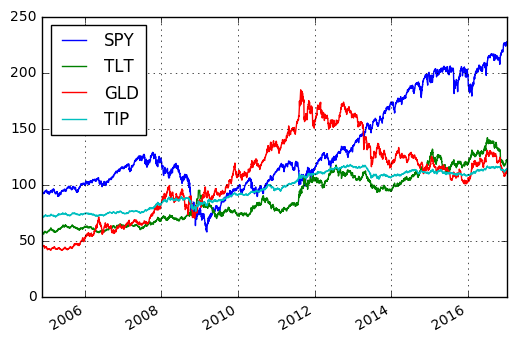

In [6]:
figure()
C.plot(grid=True)

In [7]:
R = C.pct_change() #代表每日收益率

In [9]:
R.head()

,SPY,TLT,GLD,TIP
2004-11-18,NaN,NaN,NaN,NaN
2004-11-19,-0.011117,-0.007980,0.009013,-0.002746
2004-11-22,0.004769,0.005212,0.003796,0.004463
2004-11-23,0.001526,0.001240,-0.004449,-0.001891
2004-11-24,0.002370,0.000000,0.006704,0.002652


In [15]:
weight = pd.Series({'SPY':25, 'TLT':25, 'GLD':25, 'TIP':25}) #设定每只股票权重为25
weight

GLD    25
SPY    25
TIP    25
TLT    25
dtype: int64

In [16]:
pnl = pd.DataFrame(index=C.index) #建立一个DF用来存储仓位，其index与收盘价序列一致
pnl['strategy'] = (R * weight).sum(axis=1) #这里不是dot乘积，是直接乘，然后横向加总(excel验证过)。这里是每天balance的portfolio的当日盈利情况

In [19]:
pnl.head()

,strategy
2004-11-18,0.000000
2004-11-19,-0.320758
2004-11-22,0.456022
2004-11-23,-0.089368
2004-11-24,0.293145


In [21]:
pnl['SPY'] = 100 * C['SPY'].pct_change() #计算如果买100块的spy，每天的收益金额。看样也是每天balance。

In [23]:
pnl['SPY'].head()

2004-11-18         NaN
2004-11-19   -1.111672
2004-11-22    0.476925
2004-11-23    0.152568
2004-11-24    0.236966
Name: SPY, dtype: float64

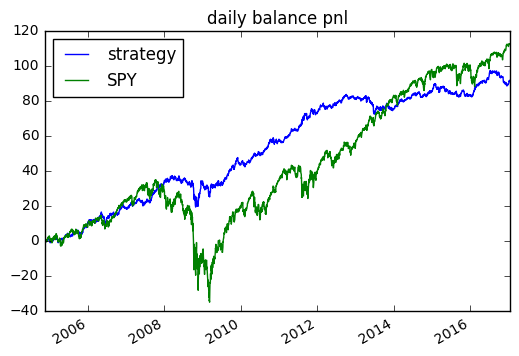

In [30]:
figure()
pnl.cumsum().plot()
title('daily balance pnl') #每日调仓的累积收益，从0涨起来

In [33]:
print('---calculate sharpe ratio')
print(twp.sharpe(pnl)) #对于twp.sharpe的输入参数，应该是每日收益数，而不是每日收益百分比。 

---calculate sharpe ratio
strategy    0.957791
SPY         0.476375
dtype: float64


从上面指标看，strategy 比简单持有spy要表现好一些。 

max daily drawdown 5.90


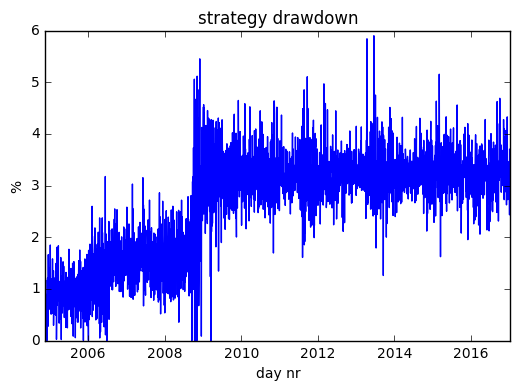

In [41]:
d, t = twp.drawdown(pnl['strategy']) #输入每日收益情况，直接计算最大回撤
plot(d)
title('strategy drawdown')
xlabel('day nr')
ylabel('%')
print('max daily drawdown %.02f' % d.max())

策略在2008年的最大回撤较大，因此考虑避免在波动性较大时间进行交易，因此引入vix指数。 

In [42]:
vix = twp.cboe.getHistoricData('VIX')['VIX'] #从cboe调取vix数据

In [43]:
vix.head()

Date
2004-01-02    18.22
2004-01-05    17.49
2004-01-06    16.73
2004-01-07    15.50
2004-01-08    15.61
Name: VIX, dtype: float64

In [45]:
vix = vix.reindex(C.index) #解决两个序列，一个长，另一个短的合并问题。

In [46]:
vix.head() #指数改为从11月开始，与C一致

2004-11-18    12.98
2004-11-19    13.50
2004-11-22    12.97
2004-11-23    12.67
2004-11-24    12.72
Name: VIX, dtype: float64

In [49]:
tradeDir = pd.Series(index=C.index, data=1) #建立一个交易方向序列。0=空仓， 1=long，-1=short，初始值都是1

In [52]:
tradeDir.head()

2004-11-18    1
2004-11-19    1
2004-11-22    1
2004-11-23    1
2004-11-24    1
dtype: int64

In [54]:
tradeDir[vix>35] = 0 #如果恐慌大于35不交易

In [68]:
tradeDir = tradeDir.shift(1) #错一个位，因为收益在第二天才有效

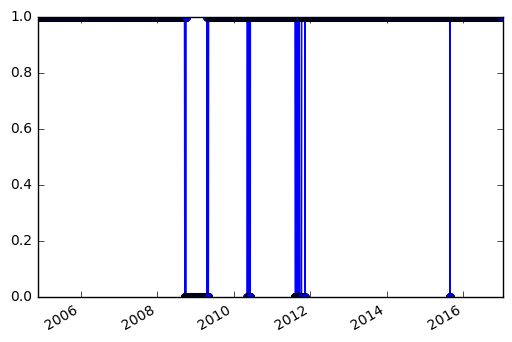

In [69]:
tradeDir.plot(style='o-')

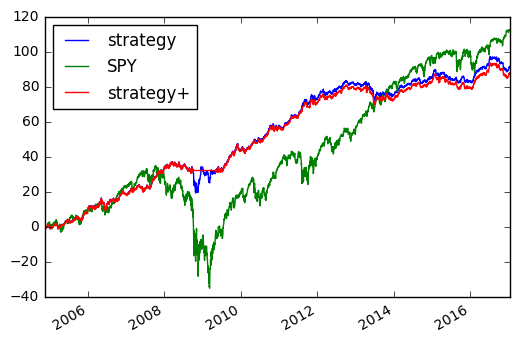

In [70]:
pnl['strategy+'] = tradeDir * (R * weight).sum(axis=1) #在高波动区域不进行交易
pnl.cumsum().plot()

In [71]:
print('calculate sharpe ratio for strategies')
print(twp.sharpe(pnl))

calculate sharpe ratio for strategies
strategy     0.957791
SPY          0.476375
strategy+    1.062826
dtype: float64


Max drawdown: 4.55 %


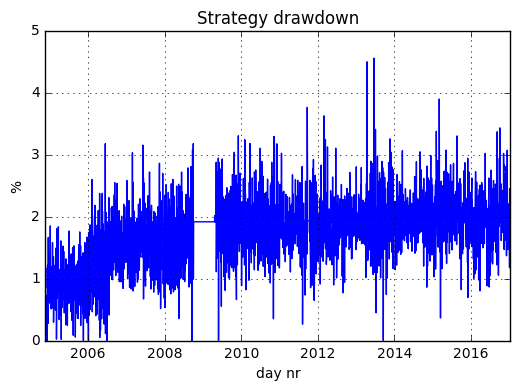

In [73]:
d,t = twp.drawdown(pnl['strategy+']) # calculate drawdown and drawdown duration
plot(d)
grid(True)
title('Strategy drawdown')
ylabel('%')
xlabel('day nr')
print('Max drawdown: %.2f %%' % d.max())